### The DAMOP sessions aren't entirely correlated with the clustered arXiv subtopics. Is this because of historical trends? Let's look at how many abstracts fit into these clusters as a function of rise and fall of subfields.

This notebooks looks for trends specifically for Nature and PRL, as a better indicator of hot topics.

In [25]:
%matplotlib inline
#Need to add parent directoy to sys.path to find 'metadataDB'
import sys
sys.path.append('../../')

%matplotlib inline
# import matplotlib.pyplot as plt
import time
import numpy as np
# import scipy as sp
import re
from collections import Counter
import itertools
import random
from datetime import date

# Natural language processing toolkit
# To use this, run nltk.download() and download 'stopwords'
# from nltk.corpus import stopwords
# s=stopwords.words('english') + ['']

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn.decomposition import SparsePCA
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
# from sklearn import metrics
from sklearn.externals import joblib

# SQL
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from metadataDB.declareDatabase import *
from sqlalchemy import or_, and_
from sqlalchemy import extract

# Graphics
from matplotlib import pyplot as plt


engine = create_engine("sqlite:///../../arXiv_metadata.db", echo=False)
Base.metadata.bind = engine
DBsession = sessionmaker(bind=engine)
session = DBsession()

In [26]:
category_list = sorted(['atom-ph']) 
journal_list = ['Nature%',
                'Nat.%',
                'Science%',
                'Physics Review Letters%',
                'Phys. Rev. Lett.%',
                'Phys.Rev.Lett.%',
                'PRL%']
clf = joblib.load('cluster-atom-ph.pkl')

In [27]:
print journal_list

['Nature%', 'Nat.%', 'Science%', 'Physics Review Letters%', 'Phys. Rev. Lett.%', 'Phys.Rev.Lett.%', 'PRL%']


In [28]:
category_len = len(category_list)

def abstracts_by_year(year):
    start = time.time()
    query = session.query(Article_Category)\
                        .join(Category)\
                        .join(Article)\
                        .filter(or_(*[Article.journal_ref.like(x) for x in journal_list]),
                                or_(*[Category.name.like('%' + x + '%') for x in category_list]),
                                Article.created >= date(year,1,1),
                                Article.created < date(year+1,1,1))
    #     query = session.query(Article_Category)\
    #                         .join(Category)\
    #                         .join(Article)\
    #                         .filter(Category.name.like('%' + item + '%'))
    result = [' '.join(x.article.abstract.split()) for x in query]
    # Remove duplicates
    result = list(set(result))
    print time.time() - start
    return result
    #     abstract_all_tmp['abstract'].extend(result)
    #     abstract_all_tmp['category'].extend([item]*len(result))


In [29]:
year_range = range(2000, 2016)
cluster_list = range(clf.get_params()['clf__n_clusters'])
data = dict([(x, dict()) for x in cluster_list])
data_normalized = dict([(x, dict()) for x in cluster_list])
articles_per_year = dict()

for year in year_range:
    current_abstracts = abstracts_by_year(year)
    articles_per_year[year] = len(current_abstracts)
    current_counter = Counter(clf.predict(current_abstracts))
    for cluster in cluster_list:
        data[cluster][year] = current_counter[cluster]
        data_normalized[cluster][year] = current_counter[cluster]*1. / articles_per_year[year]
#     break
# print data

3.29989600182
3.24872517586
3.18549203873
3.19983410835
3.14869499207
3.0962369442
3.10494494438
3.18274998665
3.23996496201
3.17056798935
3.17146992683
3.2066848278
3.32844996452
3.32894015312
3.36030292511
3.30925321579


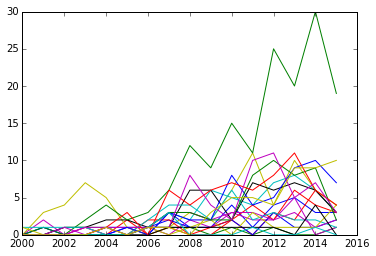

In [30]:
for cluster in cluster_list:
    plt.plot(data[cluster].keys(), data[cluster].values(), label=cluster)
# plt.legend()

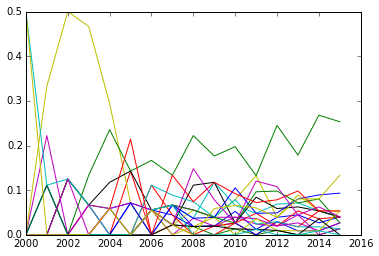

In [31]:
for cluster in cluster_list:
    plt.plot(data_normalized[cluster].keys(), data_normalized[cluster].values(), label=cluster)
# plt.legend()

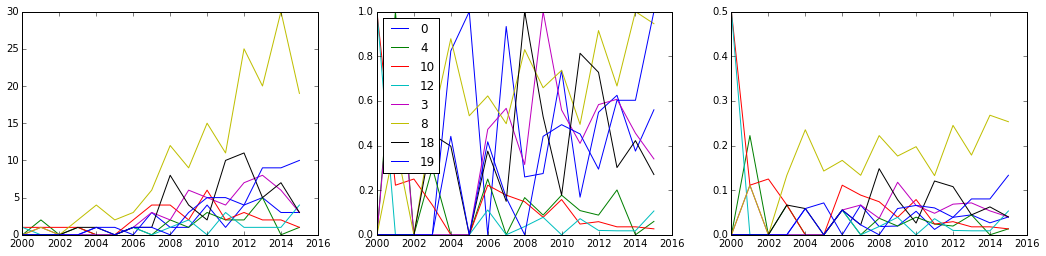

In [32]:
favorite_clusters = [0, 4, 10, 12] + [3, 8, 18, 19 ]
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
for cluster in favorite_clusters:
    plt.plot(data[cluster].keys(), data[cluster].values(), label=cluster)
# plt.legend(loc=2)


plt.subplot(1,3,2)
for cluster in favorite_clusters:
    plt.plot(data_normalized[cluster].keys(),
             [x/max(data_normalized[cluster].values()) for x in data_normalized[cluster].values()],
             label=cluster)
plt.legend(loc=2)
plt.subplot(1,3,3)
for cluster in favorite_clusters:
    plt.plot(data_normalized[cluster].keys(),
             data_normalized[cluster].values(),
             label=cluster)

(0, 0.3)

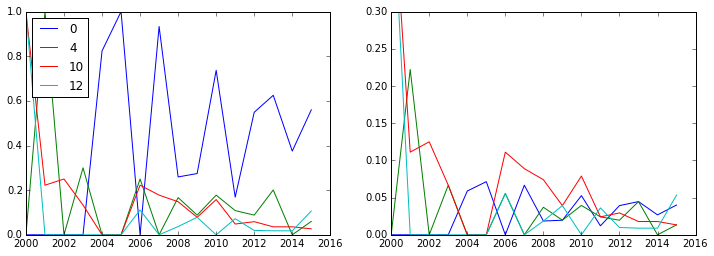

In [39]:
favorite_clusters = [0, 4, 10, 12]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for cluster in favorite_clusters:
    plt.plot(data_normalized[cluster].keys(),
             [x/max(data_normalized[cluster].values()) for x in data_normalized[cluster].values()],
             label=cluster)
plt.legend(loc=2)
plt.subplot(1,2,2)
for cluster in favorite_clusters:
    plt.plot(data_normalized[cluster].keys(),
             data_normalized[cluster].values(),
             label=cluster)
plt.ylim(0, 0.3)
# plt.legend(loc=2)

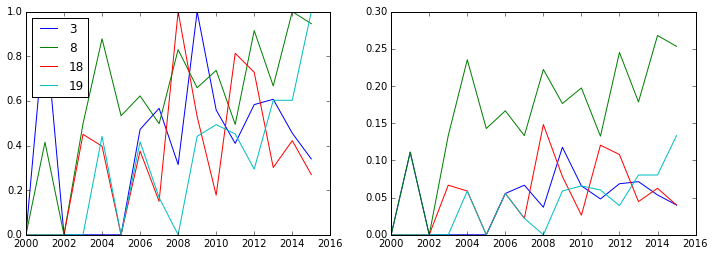

In [41]:
# favorite_cluster = [5, 8, 14, 16]
favorite_clusters = [3, 8, 18, 19 ]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for cluster in favorite_clusters:
    plt.plot(data_normalized[cluster].keys(),
             [x/max(data_normalized[cluster].values()) for x in data_normalized[cluster].values()],
             label=cluster)
plt.legend(loc=2)
plt.subplot(1,2,2)
for cluster in favorite_clusters:
    plt.plot(data_normalized[cluster].keys(),
             data_normalized[cluster].values(),
             label=cluster)

In [35]:
max(data_normalized[cluster].values())

0.13333333333333333